# Monitoring and Analysis of the experiment

So, your experiment is finally live! What should you do before resting on your laurels? Well of course, check that all is going well. What does this typically mean?

- Construct a monitoring dashboard. This is ONLY meant to catch technical issues. In the frequentist approach to A/B testing (what we've been doing so far), you should not be checking on a daily basis how your metrics are performing, because you might be a victim "peeking". 
- Check that your experiment split is actually what it theoretically should be. I.e. conduct a hypothesis test that, if the split between test/control is 50/50, then the actual proportion of users bucketed into the test group is no different than 0.5. 

And if you manage to do all of this...might as well reuse it for analysis later! Let's build all of this as a dashboard using Panel. 

## 1. Monitoring sample ratio mismatch (SRM)

Sample ratio mismatch is the situation where the ratio of samples being bucketed into one of the experimental groups is **significantly different** to what would be expected in theory. For example: 
- You expect that 50% of new users will be bucketed in to the test group. 
- Instead, out of a total of 20,000 users, 18,000 have been bucketed into the test group. 

Why do we care?

- Sample ratio mismatch is often one of the most important signals that something is wrong with the setup of the experiment. 
- Examples: app users who have bad internet connections get bucketed to "control". 
- It's better to stop the experiment early and fix the bug, than potentially sacrifice millions of observations. Remember, once a user has seen something they cannot unsee it!

If you are at the end of an experiment, you can ran a simple one-sample z-test to determine: 

H_0: Probability of being bucketed into test group = 0.5
H_1: Probability of being bucketed into test group <> 0.5

However, since we are monitoring, we will not have the experiment completed. Every day we are getting new samples. In the first few days, as the experiment is ramping up, the numbers might be very low. By running a t-test every day, we can become victims of **peeking** and an increased false positive rate. This is true for both **metrics** and **sample ratio**. See below: 

![peeking](../img/peeking.png)

The solution: If your experiment is still running, you need to use a Sequential Testing Approach, or some other methodology to avoid inflating your false positives. We will use the small package `ssrm-test`, developed by Michael Lindon at Optimizely, which helps us discover whether the experiment has sample ratio mismatch, in a control (sequential) manner. You can check out the full demo notabook for `ssrm` [here](https://github.com/ajmasci/ssrm/blob/master/notebooks/introduction.ipynb).

In [1]:
from ssrm_test import ssrm_test
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(14, 8)}
sns.set_theme(style="whitegrid", rc=custom_params, palette='bright')
%matplotlib inline

In [2]:
first_assignments = pd.read_csv("../data/first_experiment_assignments.csv", parse_dates=['bucketed_at'])
first_assignments.head(2)

,user_id,test_group,bucketed_at
0,8be9091675a4b9d8ef3dcf4dc2cdb517,control,2022-06-07 10:34:34.538675
1,86114fd22913abba540bc89ae82eff6a,test,2022-06-04 21:15:40.014207


In [3]:
control_pct = first_assignments.test_group.value_counts(normalize=True)['control']
test_pct = first_assignments.test_group.value_counts(normalize=True)['test']
print(f"Empirical sample ratios are {control_pct:.2%} and {test_pct:.2%}")

Empirical sample ratios are 51.87% and 48.13%


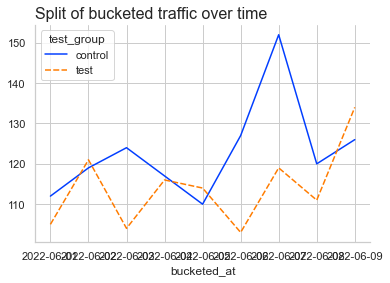

In [4]:
counts_by_day = first_assignments.groupby([first_assignments.bucketed_at.dt.date, 'test_group'])\
                                 .user_id\
                                 .nunique()\
                                 .unstack()
sns.lineplot(data=counts_by_day)
plt.title("Split of bucketed traffic over time", loc='left', size=16)
plt.show()

There probably is a problem! Let's run the data through `ssrm` to make sure we are not tricked by probability. 


_______

**SSRM**

First, we need to get our sample into a 2 dimensional numpy array format. Each element should be [control_val, test_val], i.e. a dummified representation of the group that the observation was in. We can easily do this with `pd.get_dummies()`: 

In [5]:
pd.get_dummies(assignments.test_group).head()

NameError: name 'assignments' is not defined

In [ ]:
p_0 = [0.5, 0.5] # Define the probabilities / ratios that we assume should be the Null hypothesis (usually 50/50%)

In [ ]:
pvals = ssrm_test.sequential_p_values(pd.get_dummies(assignments.test_group).values, p_0)
fig = plt.figure(figsize=(14, 8))
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("Visitor Count", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

**What conclusion would you come to from this chart and p-value?**

![confounding](../img/confounding_variable.png)

_Credit: [Lauren Thomas](https://www.scribbr.co.uk/research-methods/confounding-variable/)_

- The reasonable conclusion is that **something is wrong with the test setup that is causing a bias in the bucketing / randomization of users**. 
- These biases (even small ones) can fundamentally undermine the validity of the analysis and render the results unusable. Imagine, for example, if all users who have a bad internet connection get bucketed into control. Perhaps those users are also in locations where we don't ship our products to, so even if they browse, they **never** end up converting (extreme example). This is likely to bring down the average of the control group, artificially inflating the difference in means in favor of the test group. 
- There are two possible approaches: 
    - If you can fully identify the users that are receiving biased treatment and if you can guarantee that it's **only** them, then you can continue running the experiment, but remove those users from the later analysis. 
    - The best approach, however, is to stop the experiment, fix the issue and restart the experiment from a clean slate (with new randomization). **Note**: Users who were bucketed in the first iteration should be excluded from the subsequent analysis. 

## 2. Monitoring metrics

For each metric that we want to measure, we need to: 
- measure the values between the test groups
- keep track of how the different groups are performing over time
- visualize them in a compelling way, including any necessary splits, without compromising statistical interpretation

In [9]:
visits = pd.read_csv("../data/post_sessions.csv", parse_dates=['visit_started_at'])
payment_page_visits = pd.read_csv("../data/post_payment_page_visits.csv", parse_dates=['payment_page_accessed_at'])
purchases = pd.read_csv("../data/post_purchases.csv", parse_dates=['purchase_processed_at'])
assignments = pd.read_csv("../data/experiment_assignments.csv", parse_dates=['bucketed_at'])

In [10]:
# Merge all the dataframes together
post_df = visits.merge(
    payment_page_visits, 
    how='left', 
    on=['session_id', 'user_id']).merge(
    purchases, 
    how='left', 
    on=['session_id', 'user_id']).merge(
    assignments, 
    how='left', 
    on='user_id')

In [11]:
# Calculate a column for conversion rate to purchase for those that accessed the payment page
post_df['converted'] = ~post_df.payment_method_selected.isna() & ~post_df.purchase_processed_at.isna()
# Calculate a column for conversation rate to successful purchase for those that accessed the payment page
post_df['converted_success'] = (post_df.converted) & (post_df.status=='success')

In [12]:
post_df.shape

(33834, 19)

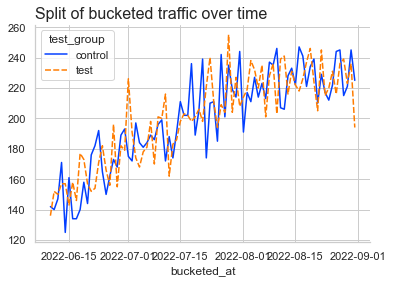

In [13]:
counts_by_day = post_df.groupby([post_df.bucketed_at.dt.date, 'test_group']).session_id.nunique().unstack()
sns.lineplot(data=counts_by_day)
plt.title("Split of bucketed traffic over time", loc='left', size=16)
plt.show()

**a) For the primary decision metric and each experimental group, compute observations, mean value, standard deviation, relative difference, 95% confidence interval of difference**. 

In [14]:
post_df[~post_df.payment_page_accessed_at.isna()].groupby('test_group')[['converted_success', 'user_id']].agg(
    {'converted_success': ['mean', 'std'],
     'user_id': ['nunique', 'count']}
)

# metric, mean_control, mean_test, N observations, diff absolute, diff relative, diff_str

converted_success           user_id      
                        mean       std nunique count
test_group                                          
control             0.672138  0.469468    6188  6884
test                0.688816  0.463011    6295  7028

In [15]:
import math

import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [16]:
def summarize_by_group(df: pd.DataFrame, 
                       metric_col:str, 
                       control_name:str='control', 
                       test_name:str='test') -> pd.DataFrame:
    """
    Returns a dataframe with the summary statistics of a specific metric, grouped by test_group
    """
    
    # Count the total observations and successes (successful purchases) in each group
    counts_control = df[df.test_group==control_name][metric_col].sum()
    nobs_control = df[df.test_group==control_name][metric_col].count()

    counts_test = df[df.test_group==test_name][metric_col].sum()
    nobs_test = df[df.test_group==test_name][metric_col].count()
    
    # Calculate the mean success rate per group, the absolute and relative difference.
    mean_control = counts_control / nobs_control
    mean_test = counts_test / nobs_test
    
    diff_abs = mean_test - mean_control
    diff_rel = (mean_test - mean_control)/mean_control
    
    # Calculate the pooled standard error to get 95% confidence intervals on the difference between the means
    # See more about this here: 
    # http://ethen8181.github.io/machine-learning/ab_tests/frequentist_ab_test.html#Comparing-Two-Proportions
    pooled_var = mean_control * (1 - mean_control) / nobs_control + mean_test * (1 - mean_test) / nobs_test
    pooled_se = np.sqrt(pooled_var)
    pooled_se
    
    ci_lower, ci_upper = diff_abs - 1.96 * pooled_se, diff_abs + 1.96 * pooled_se
    
    return pd.Series({'metric': metric_col,
                      'counts_'+control_name: nobs_control,
                      'counts_'+test_name: nobs_test,
                      'mean_'+control_name: mean_control,
                      'mean_'+test_name: mean_test,
                      'diff_abs': diff_abs,
                      'diff_rel': diff_rel,
                      'ci_95%': f'[{ci_lower:.3f} to {ci_upper:.3f}]'})

In [17]:
summarize_by_group(df=post_df[~post_df.payment_page_accessed_at.isna()], metric_col='converted_success')

metric            converted_success
counts_control                 6884
counts_test                    7028
mean_control               0.672138
mean_test                  0.688816
diff_abs                   0.016678
diff_rel                   0.024813
ci_95%             [0.001 to 0.032]
dtype: object

**b) Split the results by new/repeat user and platform used**

In [18]:
# The same function we wrote previously
def clean_platform(platform:str) -> str:
    """Returns whether a user is on Android, iOS or any kind of Desktop device"""
    if 'Android' in platform:
        return 'android'
    if ('iPad' in platform) or ('iPhone' in platform):
        return 'ios'
    else:
        return 'desktop-other'

In [19]:
post_df['new_repeat'] = post_df['last_purchase'].apply(lambda x: 'new' if pd.isna(x) else 'repeat')
post_df['platform_clean'] = post_df.platform.apply(lambda x: clean_platform(x))

In [20]:
post_df_new_users = post_df[(~post_df.payment_page_accessed_at.isna()) & (post_df.new_repeat=='new')]
summarize_by_group(df=post_df_new_users, metric_col='converted_success')

metric            converted_success
counts_control                 5375
counts_test                    5443
mean_control               0.675163
mean_test                  0.690061
diff_abs                   0.014898
diff_rel                   0.022066
ci_95%            [-0.003 to 0.032]
dtype: object

In [21]:
post_df_repeat_users = post_df[(~post_df.payment_page_accessed_at.isna()) & (post_df.new_repeat=='repeat')]
summary = summarize_by_group(df=post_df_repeat_users, metric_col='converted_success')

**Repeat a) and b) for all secondary metrics**

Now you see, it would benefit to write a function to show us a variety of splits. 

In [22]:
def calculate_metrics(base_df:pd.DataFrame, cols_to_split_on:list, metrics:list) -> pd.DataFrame:
    """
    Given a set of columns to split on and a set of metrics to calculate,
    this function returns a Pandas dataframe with one row for every metric and user group
    """
    result = []
    for m in metrics:
        summary = summarize_by_group(df=base_df, metric_col=m)
        summary['user_group'] = 'all-up'
        result.append(summary)
        
        for col in cols_to_split_on:
            unique_vals = base_df[col].unique()
            for val in unique_vals:
                df = base_df[base_df[col]==val]
                summary = summarize_by_group(df=df, metric_col=m)
                summary['user_group'] = val
                result.append(summary)
                
    return pd.DataFrame(result)

In [23]:
calculate_metrics(base_df=post_df[~post_df.payment_page_accessed_at.isna()],
                  cols_to_split_on=['new_repeat', 'platform_clean'],
                  metrics=['converted', 'converted_success'])

,metric,counts_control,counts_test,mean_control,mean_test,diff_abs,diff_rel,ci_95%,user_group
0,converted,6884,7028,0.802731,0.806488,0.003757,0.004681,[-0.009 to 0.017],all-up
1,converted,5375,5443,0.806884,0.804887,-0.001997,-0.002475,[-0.017 to 0.013],new
2,converted,1509,1585,0.787939,0.811987,0.024048,0.030521,[-0.004 to 0.052],repeat
3,converted,2517,2665,0.804926,0.807129,0.002203,0.002737,[-0.019 to 0.024],desktop-other
4,converted,3106,3082,0.795879,0.804023,0.008144,0.010233,[-0.012 to 0.028],android
5,converted,1261,1281,0.815226,0.811085,-0.004141,-0.005079,[-0.034 to 0.026],ios
6,converted_success,6884,7028,0.672138,0.688816,0.016678,0.024813,[0.001 to 0.032],all-up
7,converted_success,5375,5443,0.675163,0.690061,0.014898,0.022066,[-0.003 to 0.032],new
8,converted_success,1509,1585,0.661365,0.684543,0.023177,0.035045,[-0.010 to 0.056],repeat
9,converted_success,2517,2665,0.676996,0.693433,0.016437,0.024279,[-0.009 to 0.042],desktop-other


**Write a function that will plot the metric evolution over time for any given metric**

In [24]:
def plot_metric_over_time(df:pd.DataFrame, metric_col:str, date_col:str, aggregation:str) -> plt.Figure:
    """
    For a given metric, plots the evolution of this metric over time. 
    """
    per_day = df.groupby(['test_group', df[date_col].dt.date])[metric_col]\
                .agg([aggregation])\
                .reset_index()
    
    fig = plt.Figure(figsize=(10, 6))
    ax  = fig.add_subplot()
    sns.lineplot(data=per_day, x=date_col, y=aggregation, hue='test_group', ax=ax)
    ax.set_title(f"Evolution of {metric_col.upper()} over time: {aggregation}", loc='left', size=16)
    return fig

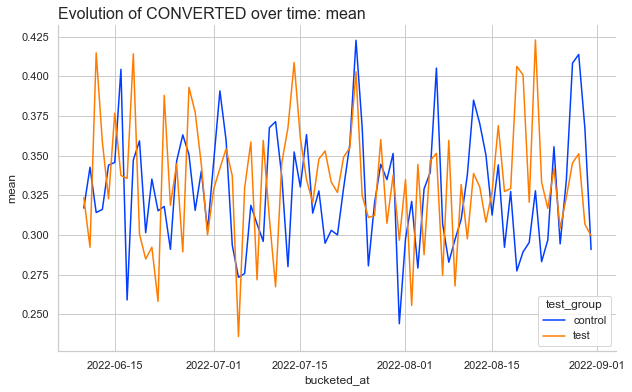

In [28]:
plot_metric_over_time(df=post_df, metric_col='converted', date_col='bucketed_at', aggregation='mean')

**What about statistical testing and p-values? Why didn't we include those?**
Showing p-values during the experiment (before we've reached the desired sample size) can mean not only that our results will not be significant for a while, but also checking every day WILL lead to an increased probability of seeing at least 1 false positive (calling the experiment a "success" when it's actually not). 

Also, when we add more metrics and more slices of the same data, we might be actually doing what is called p-hacking:

> **p-hacking**: is the misuse of data analysis to find patterns in data that can be presented as statistically significant, thus dramatically increasing and understating the risk of false positives. This is done by performing many statistical tests on the data and only reporting those that come back with significant results. [Wikipedia](https://en.wikipedia.org/wiki/Data_dredging)


Some guidelines on p-values and calling anything significant:

- Only display "significance" values when the agreed on sample size is reached, that is _at the end of the experiment_
- For any other metrics or splits, consider adjusting down the p-value that you are comparing to. For example, you could use the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html#:~:text=The%20Bonferroni%20correction%20is%20a,the%20set%20of%20all%20comparisons)) (very strict), or the [Benjamini-Hochberg correction](https://www.biostathandbook.com/multiplecomparisons.html) (a bit harder to calculate).



**Let's modify the original function to show us also p-values.** 

Add some logic to check whether the metric is the primary decision metric or not. 

In [29]:
def summarize_by_group2(df: pd.DataFrame, 
                        metric_col:dict, 
                        primary_decision_metric:bool,
                        control_name:str='control', 
                        test_name:str='test',
                        all_up: bool=False,
                        alpha:float=0.05) -> pd.DataFrame:
    """
    Returns a dataframe with the summary statistics of a specific metric, grouped by test_group
    """
    
    # Count the total observations and successes (successful purchases) in each group
    counts_control = df[df.test_group==control_name][metric_col].sum()
    nobs_control = df[df.test_group==control_name][metric_col].count()

    counts_test = df[df.test_group==test_name][metric_col].sum()
    nobs_test = df[df.test_group==test_name][metric_col].count()
    
    # Calculate the mean success rate per group, the absolute and relative difference.
    mean_control = counts_control / nobs_control
    mean_test = counts_test / nobs_test
    
    diff_abs = mean_test - mean_control
    diff_rel = (mean_test - mean_control)/mean_control
    
    # Calculate the pooled standard error to get 95% confidence intervals on the difference between the means
    # See more about this here: 
    # http://ethen8181.github.io/machine-learning/ab_tests/frequentist_ab_test.html#Comparing-Two-Proportions
    pooled_var = mean_control * (1 - mean_control) / nobs_control + mean_test * (1 - mean_test) / nobs_test
    pooled_se = np.sqrt(pooled_var)
    pooled_se
    
    ci_lower, ci_upper = diff_abs - 1.96 * pooled_se, diff_abs + 1.96 * pooled_se
    
    if primary_decision_metric and all_up:
        metric_type = 'primary'
        _, p_val = proportions_ztest(count=[counts_control, counts_test], nobs=[nobs_control, nobs_test])

    else:
        metric_type = 'secondary'
        p_val = np.NaN
        
    if p_val < 0.05:
        sig = '*'
    else: 
        sig = ''
    
    return pd.Series({'metric': metric_col,
                      'metric_type': metric_type,
                      'counts_'+control_name: nobs_control,
                      'counts_'+test_name: nobs_test,
                      'mean_'+control_name: mean_control,
                      'mean_'+test_name: mean_test,
                      'diff_abs': diff_abs,
                      'diff_rel': diff_rel,
                      'ci_95%': f'[{ci_lower:.3f} to {ci_upper:.3f}]',
                      'p-value': p_val,
                      'sig':sig})

In [31]:
def calculate_metrics2(base_df:pd.DataFrame, cols_to_split_on:list, metrics:dict) -> pd.DataFrame:
    """
    Given a set of columns to split on and a set of metrics to calculate,
    this function returns a Pandas dataframe with one row for every metric and user group
    
    Metrics need to be passed as a dictionary indicating if each metric is the primary
    decision metric or not. 
    """
    result = []
    
    for m, primary in metrics.items():
        summary = summarize_by_group2(df=base_df, metric_col=m, primary_decision_metric=primary, all_up=True)
        summary['user_group'] = 'all-up'
        result.append(summary)
        
        for col in cols_to_split_on:
            unique_vals = base_df[col].unique()
            for val in unique_vals:
                df = base_df[base_df[col]==val]
                summary = summarize_by_group2(df=df, metric_col=m, primary_decision_metric=primary, all_up=False)
                summary['user_group'] = val
                result.append(summary)
                
    return pd.DataFrame(result)

In [32]:
calculate_metrics2(base_df=post_df[~post_df.payment_page_accessed_at.isna()],
                   cols_to_split_on=['new_repeat', 'platform_clean'],
                   metrics={'converted': False, 'converted_success': True})

,metric,metric_type,counts_control,counts_test,mean_control,mean_test,diff_abs,diff_rel,ci_95%,p-value,sig,user_group
0,converted,secondary,6884,7028,0.802731,0.806488,0.003757,0.004681,[-0.009 to 0.017],NaN,,all-up
1,converted,secondary,5375,5443,0.806884,0.804887,-0.001997,-0.002475,[-0.017 to 0.013],NaN,,new
2,converted,secondary,1509,1585,0.787939,0.811987,0.024048,0.030521,[-0.004 to 0.052],NaN,,repeat
3,converted,secondary,2517,2665,0.804926,0.807129,0.002203,0.002737,[-0.019 to 0.024],NaN,,desktop-other
4,converted,secondary,3106,3082,0.795879,0.804023,0.008144,0.010233,[-0.012 to 0.028],NaN,,android
5,converted,secondary,1261,1281,0.815226,0.811085,-0.004141,-0.005079,[-0.034 to 0.026],NaN,,ios
6,converted_success,primary,6884,7028,0.672138,0.688816,0.016678,0.024813,[0.001 to 0.032],0.034911,*,all-up
7,converted_success,secondary,5375,5443,0.675163,0.690061,0.014898,0.022066,[-0.003 to 0.032],NaN,,new
8,converted_success,secondary,1509,1585,0.661365,0.684543,0.023177,0.035045,[-0.010 to 0.056],NaN,,repeat
9,converted_success,secondary,2517,2665,0.676996,0.693433,0.016437,0.024279,[-0.009 to 0.042],NaN,,desktop-other


_________

Let's put this all together into a simple dynamic dashboard using `panel`. 

**Write a function that for each metric will show a table of its most common splits**

In [40]:
import panel as pn
pn.extension()

import param

class MetricEvolution(param.Parameterized):
    metric_col = param.Selector(objects=['converted', 'converted_success'])
    aggregation = param.Selector(objects=['mean', 'count'])

    def view(self):
        return plot_metric_over_time(
            df=post_df[~post_df.payment_page_accessed_at.isna()], 
            metric_col=self.metric_col, 
            date_col='bucketed_at', 
            aggregation=self.aggregation)
    
obj = MetricEvolution()
obj

MetricEvolution(aggregation='mean', metric_col='converted', name='MetricEvolution00146')

Column
    [0] Column(margin=5, name='MetricEvolution', width=300)
        [0] StaticText(value='<b>MetricEvolution</b>')
        [1] Select(name='Metric col', options=OrderedDict([('converted',...]), value='converted')
        [2] Select(name='Aggregation', options=OrderedDict([('mean', ...]), value='mean')
    [1] ParamMethod(method)
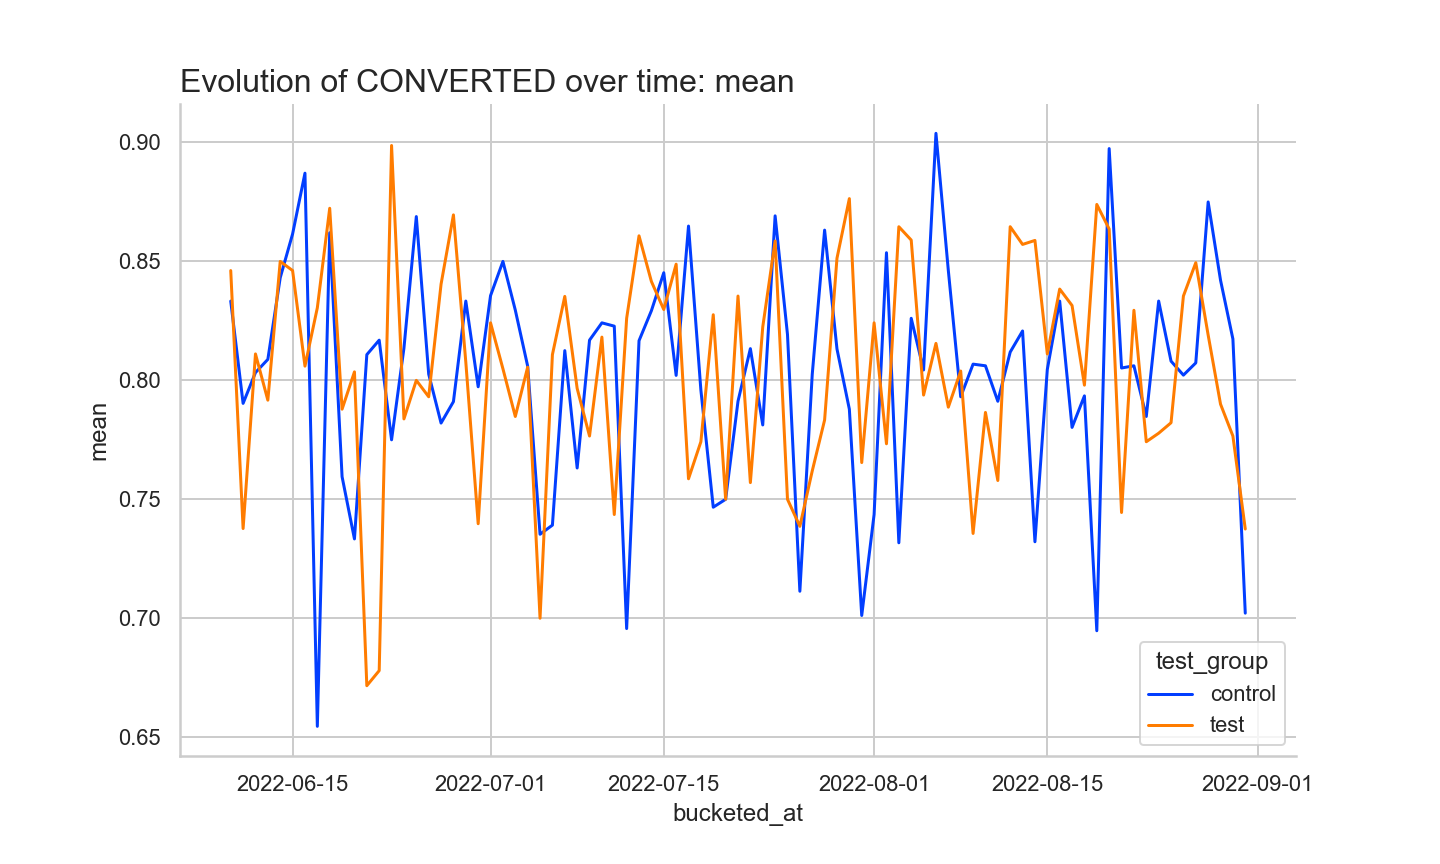

In [41]:
pn.Column(obj.param, obj.view)

**Write a function that for a given metric, will show its evolution over time in the experiment groups**

In [43]:
calculate_metrics2(base_df=post_df[~post_df.payment_page_accessed_at.isna()],
                   cols_to_split_on=['new_repeat', 'platform_clean'],
                   metrics={'converted': False, 'converted_success': True})

,metric,metric_type,counts_control,counts_test,mean_control,mean_test,diff_abs,diff_rel,ci_95%,p-value,sig,user_group
0,converted,secondary,6884,7028,0.802731,0.806488,0.003757,0.004681,[-0.009 to 0.017],NaN,,all-up
1,converted,secondary,5375,5443,0.806884,0.804887,-0.001997,-0.002475,[-0.017 to 0.013],NaN,,new
2,converted,secondary,1509,1585,0.787939,0.811987,0.024048,0.030521,[-0.004 to 0.052],NaN,,repeat
3,converted,secondary,2517,2665,0.804926,0.807129,0.002203,0.002737,[-0.019 to 0.024],NaN,,desktop-other
4,converted,secondary,3106,3082,0.795879,0.804023,0.008144,0.010233,[-0.012 to 0.028],NaN,,android
5,converted,secondary,1261,1281,0.815226,0.811085,-0.004141,-0.005079,[-0.034 to 0.026],NaN,,ios
6,converted_success,primary,6884,7028,0.672138,0.688816,0.016678,0.024813,[0.001 to 0.032],0.034911,*,all-up
7,converted_success,secondary,5375,5443,0.675163,0.690061,0.014898,0.022066,[-0.003 to 0.032],NaN,,new
8,converted_success,secondary,1509,1585,0.661365,0.684543,0.023177,0.035045,[-0.010 to 0.056],NaN,,repeat
9,converted_success,secondary,2517,2665,0.676996,0.693433,0.016437,0.024279,[-0.009 to 0.042],NaN,,desktop-other


## 3. Reporting on experiments 

Let's try writing down how we would report on this test. 

**Use function created above to generate results table and visualize them**

**Summarize your conclusion on the test. Was the null hypothesis rejected? What would you recommend to the product manager?**